# House Prices: Advanced Regression Techniques
Joanna Broniarek
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
---------------

Before starting project I decided to read some articles:
1. https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

    + Select Data: Integrate data, de-normalize it into a dataset, collect it together.
    + Preprocess Data: Format it, clean it, sample it so you can work with it.
    + Transform Data: Feature Engineer happens here.
    + Model Data: Create models, evaluate them and tune them.
    + 
2. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

2. 6 top factors  that influence a home’s value: https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/
3. https://www.rochesterrealestateblog.com/what-factors-influence-the-sale-price-of-a-home/
_______________

Data tidying
1. removed rows with > 90% NA
2. removed outliers (var X > mean(X) + 3*sd(X)) ----> Z-score method
3. normalization…

Feature engineering
1. created feature MyFoo defined as XYZ that captures aspect ABC
…

Modelization
1. linear regression
2. clustering on features A, B, C

Training
1. average of 10-folds cross validation
2. LASSO model selection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler
# from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sys
# import re
import sklearn_pandas
import numpy as np

#Remember to change the path!!!

path = r'C:\Users\Asia\Desktop\FUW17-18\kaggle-titanic-master\category_encoders-1.2.6'
sys.path.insert(0, path)
from category_encoders import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

### Reading CSV file as Dataframe:

In [265]:
data_df = pd.read_csv("C:/Users/Asia/fdf_kaggle_project/train.csv")
test_df = pd.read_csv("C:/Users/Asia/fdf_kaggle_project/test.csv")

### EDA - Exploratory Data Analysis

Firstly, I provided some analysis of our data.

In [197]:
len(data_df.columns)

81

In [198]:
data_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


I noticed that the dataset consists of 38 numerical columns of 81 all. 
Morover, some columns contain missing data, i.e."LotFrontage", "MasVnrArea".

**The label which I would like to predict is 'SalePrice'. Let's look closer to this column.**

In [199]:
# Basic information:
# data_df['SalePrice'].describe()

In [200]:
# The Density Plot
# sns.distplot(data_df['SalePrice']) #TODO: add titles!

**It is right-skewed distribution with the pick around 160k and quite long tail with maximum about 800k. **

In [201]:
#Skeweness
# data_df['SalePrice'].skew()

## Data tidying

+  **Removing columns with Nan values**

Checking the percentage of Nan values in dataframe. The columns with value > 0.9 will be removed.

Getting names of columns to drop out:

In [202]:
col_nan = data_df.isna().sum() / data_df.shape[0]
drop_out_columns = data_df.columns[[inx for inx, i in enumerate(col_nan >= 0.9) if i==True]]
drop_out_columns

Index(['Alley', 'PoolQC', 'MiscFeature'], dtype='object')

In [203]:
data_df = data_df.drop(drop_out_columns, axis=1)
test_df = test_df.drop(drop_out_columns, axis=1)

Drop "Id" column:

In [204]:
data_df = data_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

Removing rows where SalePrice is NAN:

In [205]:
data_df = data_df.dropna(subset=['SalePrice'])

In [206]:
# data_df.SalePrice - do usuniecia 

In [65]:
# any(np.isfinite(data_df.SalePrice)==False) - do usuniecia 

+ **Removing outliers**

I will use **Z-score method** to detect the outliers. Z-scores are expressed in terms of standard deviations from their means. As a result, these z-scores have a distribution with a mean of 0 and a standard deviation of 1.  

I will set a **threshold = 3** to identify outliers.
$$ z = \frac{x - \mu}{\sigma} $$


In [250]:
#!!!!!!!!! TODO: ta funkcja nie dziala dobrze

def remove_outliers(dataset, threshold, columns=None):
    """ Z-score method """
    # If columns=None transform all numerical columns:
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns
        
    num_df = dataset[['OverallQual']]
    z = np.abs(stats.zscore(num_df))
#     is_not_outlier = z < threshold
#     print(len(is_not_outlier))
# #     is_outlier = df.apply(lambda x: np.abs(x - x.mean()) / x.std() < threshold).all(axis=1)
# #     clear_data = 
#     print(num_df[[is_not_outlier]])
    
    dataset['OverallQual'] = num_df[z < threshold]
    return dataset

In [268]:
tmp = data_df.copy()
z = np.abs(stats.zscore(tmp['OverallQual']))
print(np.where(z < 1))
tmp['Street'] = tmp['OverallQual'][z < 3]
tmp['Street'].head() 

(array([   0,    1,    2, ..., 1457, 1458, 1459], dtype=int64),)


0    7.0
1    6.0
2    7.0
3    7.0
4    8.0
Name: Street, dtype: float64

In [255]:
data_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


In [252]:
clear_data = remove_outliers(dataset=data_df, threshold = 0) #columns=['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'FullBath']
print("Previously: {} rows \nAfter cleaning: {} rows".format(len(data_df), len(clear_data)))
clear_data.head()

Previously: 1460 rows 
After cleaning: 1460 rows


c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


### EDA

+ Now, I would like to know more about relationships between features

Let's make **heatmap of correlations** to get the overall look at data.

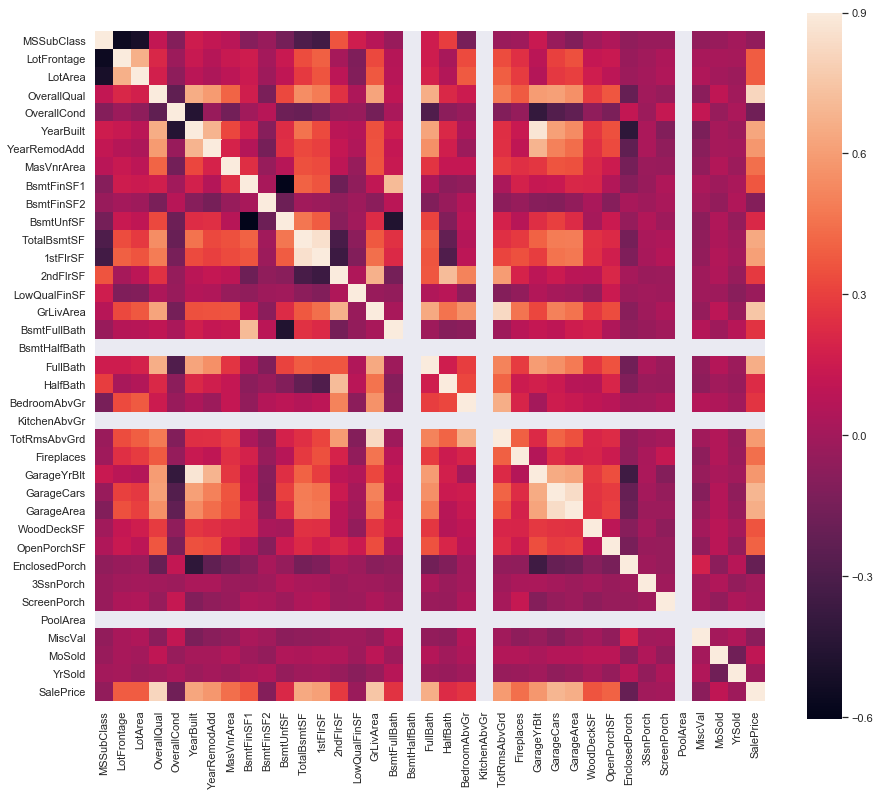

In [147]:
#correlation matrix
corrmat = clear_data.corr()
f, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(corrmat, vmax=.9, square=True)

We found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ Strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ the same situation is between TotRmsAbvGrd and GrLivArea. What seems to be rational. 
+ Morover, some columns seems to be useless in terms of the house price prediction, so I remove them for further analysis. 

In [17]:
# Most correlated NUMERICAL columns with the SalePrice column
corrmat[np.abs(corrmat['SalePrice']) > 0.5]['SalePrice']

OverallQual     0.802325
YearBuilt       0.576751
YearRemodAdd    0.539315
TotalBsmtSF     0.624148
1stFlrSF        0.591168
GrLivArea       0.694729
FullBath        0.549423
GarageYrBlt     0.517229
GarageCars      0.651585
GarageArea      0.633848
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [18]:
interesting_columns = ['OverallQual','YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'FullBath']

In [74]:
selected_features_df = clear_data[interesting_columns]
selected_features_df.head()

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,7,2003,856,1710.0,2,2
1,6,1976,1262,1262.0,2,2
2,7,2001,920,1786.0,2,2
3,7,1915,756,1717.0,3,1
4,8,2000,1145,2198.0,3,2


In [72]:
y = clear_data['SalePrice'].as_matrix()

In [75]:
selected_features_df.describe()

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,GarageCars,FullBath
count,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000
mean,5.999288,1970.539886,1024.215100,1465.965812,1.730057,1.539886
std,1.293384,29.908494,384.563048,445.220091,0.726591,0.534462
min,1.000000,1872.000000,0.000000,334.000000,0.000000,0.000000
25%,5.000000,1953.000000,788.750000,1120.000000,1.000000,1.000000
50%,6.000000,1972.000000,975.500000,1440.000000,2.000000,2.000000
75%,7.000000,2000.000000,1252.250000,1728.000000,2.000000,2.000000
max,10.000000,2009.000000,3206.000000,2810.000000,4.000000,3.000000


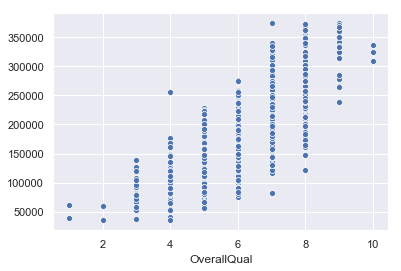

In [76]:
#scatterplot
clear_data = pd.DataFrame(clear_data)
sns.set()
ax = sns.scatterplot(x="OverallQual", y=y, data=clear_data)

In [77]:
# any(np.nan==y)
# type(y[(np.isfinite(y))==False][0])

In [78]:
num_features = sklearn_pandas.gen_features(columns=[['OverallQual'], ['TotalBsmtSF'],['GrLivArea'],['GarageCars'],['FullBath']], classes=[SimpleImputer])#, StandardScaler])
mapper = sklearn_pandas.DataFrameMapper(num_features)
scaled_features = mapper.fit_transform(selected_features_df.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=selected_features_df.index, columns=['OverallQual', 'TotalBsmtSF','GrLivArea','GarageCars', 'FullBath'])
# scaled_features_df = scaled_features_df.reset_index()

In [82]:
scaled_features_df.head()

,index,OverallQual,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,0,7.0,856.0,1710.0,2.0,2.0
1,1,6.0,1262.0,1262.0,2.0,2.0
2,2,7.0,920.0,1786.0,2.0,2.0
3,3,7.0,756.0,1717.0,3.0,1.0
4,4,8.0,1145.0,2198.0,3.0,2.0


In [135]:
# LINEAR REGRESSION
# OverallQual, 'GrLivArea', 'GarageCars', 'TotalBsmtSF'
X = scaled_features_df[['GrLivArea']].as_matrix()
# X = X.as_matrix()#.astype(np.float)

# y = clear_data[['SalePrice']]
reg = LinearRegression()
reg.fit(X, y)

print("Score: {0} \nCoeff: {1}".format(reg.score(X, y), reg.coef_))

Score: 0.4892473570723962 
Coeff: [97.64768661]


In [136]:
yfit1 = reg.coef_[0]*X[:,0]
len(yfit)

1404

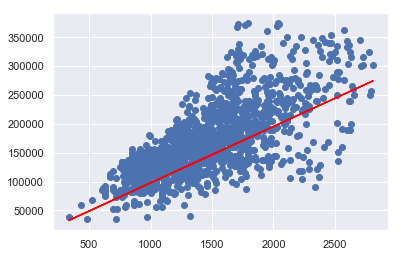

In [138]:
# PLOTTING

plt.scatter(X[:, 0], y)
plt.plot(X[:, 0], yfit1, color="red");
plt.show()

In [139]:
reg.predict()

ValueError: could not convert string to float: 'Normal'

##### SALES PRiCE outliers
To make SalePrice from normal distrobution we can use log-transformation.

In [82]:
# data_df['SalePrice'] df.a.
# sns.distplot(data_df['SalePrice'].astype(int))

In [83]:
# res = stats.probplot(clear_data['SalePrice'], plot=plt, dist='norm', fit=True)
# print("R^2 = ", res[1][2])

After logaritmic transformation

In [84]:
# log_SalePrice = np.log(clear_data['SalePrice'])
# sns.distplot(log_SalePrice)

In [85]:
# res2 = stats.probplot(log_SalePrice, plot=plt, dist='norm', fit=True)
# print("R^2 = ", res2[1][2])

In [86]:
# price_df = data_df[['SalePrice']]
# is_outlier = price_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)

Removing outliers for numerical columns

In [87]:
# data_df = data_df[is_outlier]

In [88]:
# print("After removing outliers of SalePrices, the number of observations is {}".format(len(data_df)))

### Neighborhood - categorical to numeral -- Label encoding

In [187]:
nghb = data_df['Neighborhood'].unique()
nghb

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'ClearCr', 'NPkVill', 'StoneBr', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [209]:
data_df['Neighborhood'] = data_df['Neighborhood'].astype('category')
data_df['Neighborhood_num'] = data_df['Neighborhood'].cat.codes
data_df.head()    

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Neighborhood_num
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,2,2008,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,0,5,2007,WD,Normal,181500,24
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2008,WD,Normal,223500,5
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,0,2,2006,WD,Abnorml,140000,6
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,0,12,2008,WD,Normal,250000,15


### KitchenQual - Label encoding

In [216]:
# kitchen_le = LabelEncoder()
# kitchen_le.fit(list(data_df.loc[:,('KitchenQual')]))
# kitchen_le.classes_
# data_df.loc[:,('KitchenQual')] = kitchen_le.transform(list(data_df.loc[:,('KitchenQual')]))  

In [275]:
# data_df[['KitchenQual']].head()

### Label Encoding

In [290]:
# num_features = sklearn_pandas.gen_features(['LandContour'], StringIndexer)
cat_features = [(['LandContour'], LabelEncoder()), (['KitchenQual'], LabelEncoder()), (['Neighborhood'], LabelEncoder())]

In [291]:
data_pipe = sklearn_pandas.DataFrameMapper(cat_features, df_out=True, input_df=True)

In [292]:
train = data_pipe.fit_transform(data_df, data_df.SalePrice)

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [293]:
data_df['LandContour'] = train['LandContour']
data_df['KitchenQual'] = train['KitchenQual']
data_df['Neighborhood'] = train['Neighborhood']

In [294]:
data_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,3,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,3,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,3,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,3,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,3,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


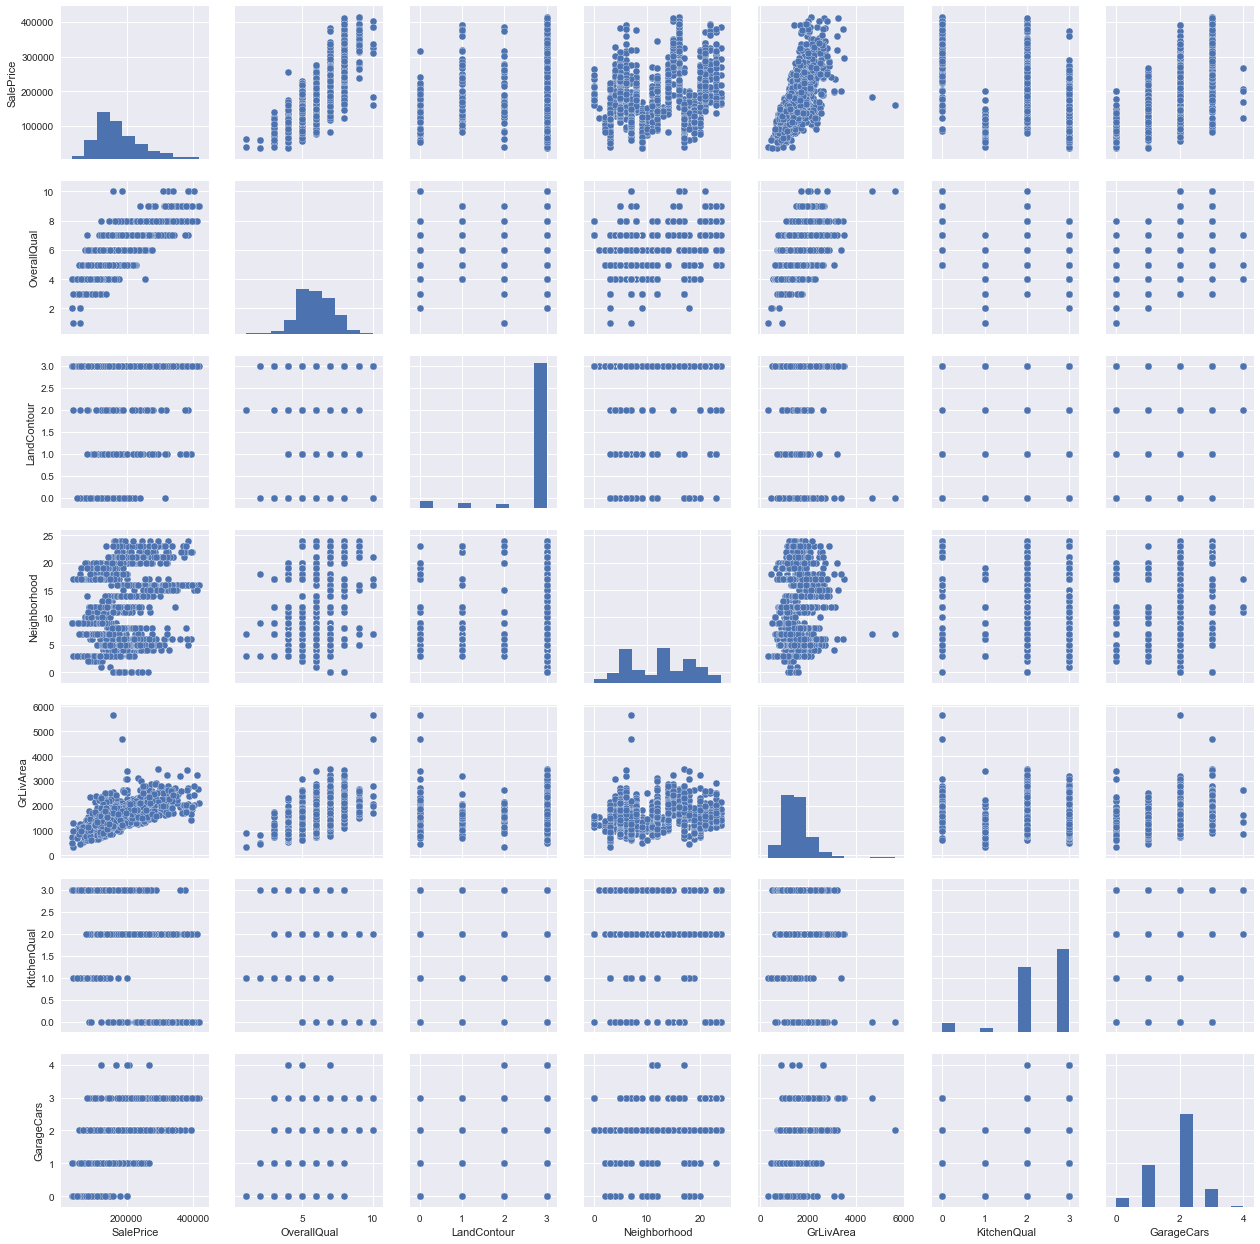

In [295]:
#scatterplot
sns.set()
cols = ["SalePrice", "OverallQual", "LandContour", "Neighborhood", "GrLivArea", "KitchenQual", "GarageCars"]
sns.pairplot(data_df[cols], size = 2.5)
plt.show()

In [ ]:
# numerics = ['int64','float64']
# new_df = data_df.select_dtypes(include=numerics)
# len(new_df.columns)

In [305]:
new_df = data_df[["SalePrice", "OverallQual", "Neighborhood", "GrLivArea", "KitchenQual", "GarageCars"]]

In [313]:
new_df.drop(columns=['SalePrice']).head()

,OverallQual,Neighborhood,GrLivArea,KitchenQual,GarageCars
0,7,5,1710,2,2
1,6,24,1262,3,2
2,7,5,1786,2,2
3,7,6,1717,2,3
4,8,15,2198,2,3


In [300]:
new_df.corr()['SalePrice']

SalePrice       1.000000
OverallQual     0.796343
Neighborhood    0.196283
GrLivArea       0.670485
KitchenQual    -0.548128
GarageCars      0.651158
Name: SalePrice, dtype: float64

### Feature engineering

+ Imputer - Imputation transformer for completing missing values.
''' missing_values : integer or “NaN”, optional (default=”NaN”)

The placeholder for the missing values. All occurrences of missing_values will be imputed. For missing values encoded as np.nan, use the string value “NaN”.

strategy : string, optional (default=”mean”)

The imputation strategy.

If “mean”, then replace missing values using the mean along the axis.
If “median”, then replace missing values using the median along the axis.
If “most_frequent”, then replace missing using the most frequent value along the axis. '''

+ Standarizing by StandardScaler

In [35]:
num_features = sklearn_pandas.gen_features(columns=[['col1'], ['col2'], ['col3']], classes=[Imputer, StandardScaler])
num_features

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[(['col1'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['col2'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['col3'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)])]

In [30]:
# num_features = sklearn_pandas.gen_features([['SibSp'], ['Parch'], ['Fare']], [Imputer])

# cat_features = [
#                 (['Pclass'], CategoricalEncoder()),
#                 (['Embarked'], CategoricalEncoder(categories=['C', 'Q', 'S'])),
#                 (['Sex'], CategoricalEncoder(categories=['female']))
#                ]

# ticket_features = [(['Ticket', 'Sex', 'PassengerId'], TicketStats(), {'alias': 'TicketStats'})]

# cabin_features = [(['Cabin'], CabinFeatures(), {'alias': 'Deck'})]

# title_features = [
#                   (['Name', 'Age'], [CleanTitles(), CategoricalImputer(set(CleanTitles.titlemap.values()), Imputer())], {'alias': 'Age'}),
#                   (['Name'], [CleanTitles(), CategoricalEncoder()], {'alias': 'Title'})
#                  ]

# data_pipe = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features + ticket_features, df_out=True, input_df=True)
# data_pipe_no_ticket = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features, df_out=True, input_df=True)

In [ ]:
mapper = DataFrameMapper([(df.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [235]:
class StringIndexer(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.categories].apply(lambda s: s.cat.codes.replace({-1: len(s.cat.categories)}))

In [80]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
    
    def get_feature_names(self):
        if self.categories is None:
            return [c for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping']]
        else:
            return self.categories
        
    def fit(self, X, y=None):
        try:
            self.onehotencoder_ = OneHotEncoder(cols = list(X.columns), return_df=False, handle_unknown='ignore')
        except AttributeError:
            self.onehotencoder_ = OneHotEncoder(return_df=False, handle_unknown='ignore')
        self.onehotencoder_.fit(X)
        
    def transform(self, X):
        res = self.onehotencoder_.transform(X)
        if self.categories is not None:
            idxs = [i for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping'] if c in set(self.categories)]
            return res[:, idxs]
        return res

Reading the **train.csv** file:

----------
+ "Alley" does not contain a lot of information, mostl;y Nan, so we can drop this column
+ Similar situation is with "PoolQC" and "MiscFeature" columns
+ 

## Correlation 

In [ ]:
#### Now, I would like to know more about relationships between features

Let's make heatmap of correlations to get the overall look at data.

= === ------------------------------

#correlation matrix
corrmat = data_df.corr()
f, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(corrmat, vmax=.9, square=True)

= === ---------------

We found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ Strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ the same situation is between TotRmsAbvGrd and GrLivArea. What seems to be rational. 
+ sth more? maybe negatively correlated?

-= ---------------= -

 Correlations between features and 'SalePrice'
 spearman_df = pd.DataFrame()
 spearman_df['feature'] = data_df.columns
 spearman_df['spearman'] = [data_df[f].corr(data_df['SalePrice'], 'spearman') for f in data_df.columns]
 sorted_spearman_df = spearman_df.sort_values('spearman')
 plt.figure(figsize=(6, 0.25*len(data_df.columns)))
 sns.barplot(data=sorted_spearman_df, y='feature', x='spearman', orient='h')
 
 -=--=================-------
 
 According to correlation and previously general informations from articles I decided to be focused on selected features like:
+ OverallQual
+ LandContour
+ Neighborhood
+ YearBuilt ??? no
+ GrLivArea
+ KitchenQual
+ Electrical ??? no
+ CentralAir ??? no
+ Fireplaces ??? no
+ GarageCars
+ PoolArea ??? no

## Linear Regression

In [320]:
from sklearn.linear_model import LinearRegression

X = new_df.drop(columns=['SalePrice'])
y = new_df[['SalePrice']]
reg = LinearRegression().fit(X, y)
reg.score(X, y)
# reg.coef_
# reg.intercept_ 
# reg.predict(test)

0.7620599642466808

In [319]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [301]:
# data_df.corr()['SalePrice']

In [302]:
# data_df.columns

In [304]:
# data_df = data_df.drop(columns=['Alley', 'PoolQC', 'MiscFeature'])
# data_df.head()

Lets check correlations and cover of the info between columns about **garage**

In [69]:
garage_df = data_df[["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]
garage_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA


In [49]:
garage_df.dtypes

GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars        int64
GarageArea        int64
GarageQual       object
GarageCond       object
dtype: object

#### Decomposition of Categorical Attributes

In [72]:
# We can convert non-numerical values to some numbers 

from sklearn import preprocessing

le1 = preprocessing.LabelEncoder()
le1.fit(list(garage_df.loc[:,('GarageQual')]))
le1.classes_
garage_df.loc[:,('GarageQual')] = le1.transform(list(garage_df.loc[:,('GarageQual')]))  

le = preprocessing.LabelEncoder()
le.fit(list(garage_df.loc[:,('GarageCond')]))
le.classes_
garage_df.loc[:,('GarageCond')] = le.transform(list(garage_df.loc[:,('GarageCond')]))  

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
garage_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,4,4
1,Attchd,1976.0,RFn,2,460,4,4
2,Attchd,2001.0,RFn,2,608,4,4
3,Detchd,1998.0,Unf,3,642,4,4
4,Attchd,2000.0,RFn,3,836,4,4


In [74]:
garage_df.corr()

,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond
GarageYrBlt,1.000000,0.588920,0.564567,0.310021,0.256680
GarageCars,0.588920,1.000000,0.882475,-0.117061,-0.162246
GarageArea,0.564567,0.882475,1.000000,-0.096674,-0.139104
GarageQual,0.310021,-0.117061,-0.096674,1.000000,0.597030
GarageCond,0.256680,-0.162246,-0.139104,0.597030,1.000000


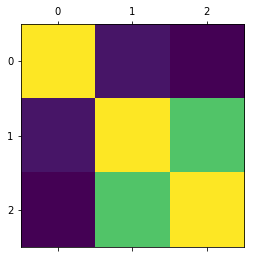

In [47]:
plt.matshow(garage_df.corr())
plt.show()

------------------
At first, I want to analyse the column "MSSubClass"

**MSSubClass:** 
+ Identifies the type of dwelling involved in the sale.

In [22]:
data[["Id", "MSSubClass"]].groupby(by="MSSubClass").count()

,Id
MSSubClass,
20,536
30,69
40,4
45,12
50,144
60,299
70,60
75,16
80,58
